In [28]:
import os, sys
project_root_dir = os.path.join(os.getcwd(),'../..')
if project_root_dir not in sys.path:
    sys.path.append(project_root_dir)

from matplotlib import pyplot as plt
import numpy as np
from torch import nn
import torch
import config

from utils import show_abundance, plot_endmembers
# from dataset import JasperRidgeDataset
from HySpecLab.metrics import rmse, sad
from scipy import io as sio


# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

In [2]:
from dataset import JasperRidge

dataset = JasperRidge(config.JasperRidge_PATH)
dataset_name = 'JasperRidge'
wv = np.array(dataset.wv, dtype=np.uint)

result_path = os.path.join(config.RESULTS_PATH, 'jasperRidge')

In [4]:
from HySpecLab.metrics import sad

def sort_endmember(endmembers, gt):
    sad_result = sad(endmembers, gt)
    e_idx = torch.argmin(sad_result, dim=0) # Index for reordering the ground truth
    return e_idx, sad_result

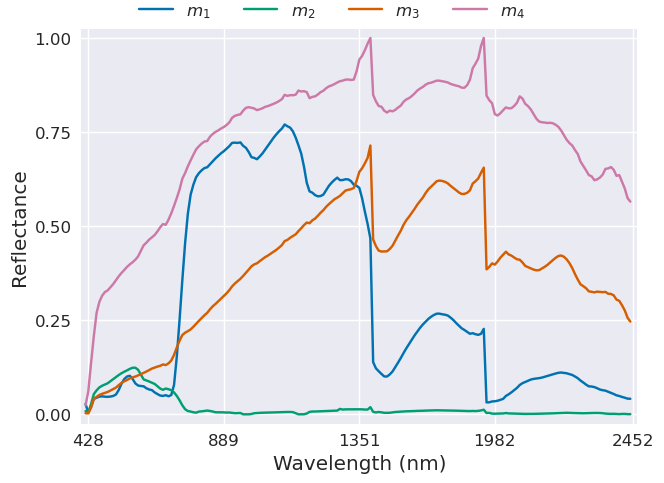

In [5]:
from HySpecLab.eea import VCA

n_endmembers = dataset.n_endmembers
   
vca = VCA(n_endmembers, snr_input=-1, random_state=25)
vca.fit(dataset.X.numpy())
endmembers = torch.from_numpy(vca.endmembers()).float()
e_idx, sad_result = sort_endmember(endmembers, dataset.endmembers())

vca_endmember_init = endmembers[e_idx]
vca_logit_endmember_init = torch.log((vca_endmember_init + 1e-12) / ((1-vca_endmember_init) + 1e-12))

fig = plot_endmembers(vca_endmember_init, wv, ticks_range=(0, 1))
plt.show(fig)

# Data

In [6]:
from scipy.io import loadmat

dataset_path = os.path.join(config.DERMA_DATASET_DIR, 'train/')
subjects = os.listdir(dataset_path)[::12]

subject_data = []
subject_target = []
for i in subjects:
    mat = loadmat(os.path.join(dataset_path, i))
    subject_data.append(mat['preProcessedImage'].astype(np.float64)[np.newaxis,:])

    mat_y = mat['groundTruthMap']
    y = np.zeros(mat_y.shape,  dtype=int)
    # benign_idx = np.where(np.logical_and(mat_y>200, mat_y<400))
    malignant_idx = np.where(np.logical_and(mat_y>=400, mat_y<500))
    # y[benign_idx] = 2
    y[malignant_idx] = 1
    subject_target.append(y[np.newaxis,:])

subject_data = np.concatenate(subject_data)
subject_target = np.concatenate(subject_target)
mean_value = subject_data[np.logical_not(np.isnan(subject_data))].mean()
subject_data = np.nan_to_num(subject_data, nan=mean_value)

AttributeError: module 'config' has no attribute 'DERMA_DATASET_DIR'

### Endmember Extraction

In [ ]:
n_endmembers = 4

#### NFINDR

In [ ]:
from pysptools import eea

ee = eea.NFINDR()
U = torch.tensor(ee.extract(subject_data.reshape(subject_data.shape[0]*subject_data.shape[1], subject_data.shape[2], -1), 
                            n_endmembers, 
                            maxit=1024, 
                            normalize=False,
                            ATGP_init=True))

#### VCA

In [ ]:
from HySpecLab.eea import VCA

eea = VCA(n_endmembers)
data = subject_data.reshape(subject_data.shape[0]*subject_data.shape[1]*subject_data.shape[2], subject_data.shape[3])
eea.fit(data)
U = torch.tensor(eea.endmembers())

#### SVDD

In [ ]:
from HySpecLab.eea import SVDD

eea = SVDD(sigma=.1, d=2, n_samples=1200, C=100)
X = subject_data.reshape(subject_data.shape[0]*subject_data.shape[1]*subject_data.shape[2], -1)
y = subject_target.reshape(subject_target.shape[0]*subject_target.shape[1] * subject_target.shape[2], -1)
eea.fit(X, y)
U = torch.tensor(eea.endmembers())

In [ ]:
from matplotlib import pyplot as plt 
plt.plot(U.T)
plt.show()

In [8]:
from torchvision.transforms import Compose, ToTensor, Resize, InterpolationMode, Normalize

transform = Compose([
    ToTensor(),
    # Resize((64,64), InterpolationMode.NEAREST),
])

In [9]:
from torch.utils.data import Dataset 
from torchvision import transforms as torchTransforms

class AuxDataset(Dataset):
    def __init__(self, data, transform=torchTransforms.Compose([torchTransforms.ToTensor()])):
        super(AuxDataset, self).__init__()
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.transform(self.data[idx])

train_set = AuxDataset(dataset.X, transform)

In [ ]:
from torch.utils.data import DataLoader

loader = DataLoader(train_set, batch_size=32, shuffle=False)
X_tensor = next(iter(loader))

In [22]:
from HySpecLab.unmixing import get_noise, NOISE_TYPE
X_tensor = torch.tensor(dataset.image()).permute(2,0,1).unsqueeze(0)
U = vca_endmember_init
noisy_input = get_noise(X_tensor.shape[1:], batch_size = X_tensor.shape[0], noise_type=NOISE_TYPE.uniform)

U_tensor = torch.unsqueeze(U.T, dim=0).float()

print('Z shape: {}'.format(noisy_input.shape))
print('HyperCube shape: {}'.format(X_tensor.shape))
print('Endmember shape: {}'.format(U_tensor.shape))

Z shape: torch.Size([1, 198, 100, 100])
HyperCube shape: torch.Size([1, 198, 100, 100])
Endmember shape: torch.Size([1, 198, 4])


In [23]:
X_tensor.shape

torch.Size([1, 198, 100, 100])

In [24]:
from HySpecLab.unmixing import UnDIP

n_bands = X_tensor.shape[1]
n_endmembers = U_tensor.shape[-1]

dims = [n_bands, 256]
skip_connection = [6]
out_channels = 64

model = UnDIP(n_endmembers, out_channels, dims, skip_connection, dropout=False, batch_norm=True, activation_func=nn.ReLU())

In [29]:
from tqdm import tqdm
# from torch.utils.tensorboard import SummaryWriter
# from torchvision.utils import make_grid
# from HySpecLab.utils import fig_to_image
from HySpecLab.unmixing.utils import restoration
from HySpecLab.metrics import UnmixingLoss

batch_size = X_tensor.shape[0]
n_bands = X_tensor.shape[1]
w, h = X_tensor.shape[2:]

n_epoch = 5000
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
criterion = UnmixingLoss()

model = model.to(device)

epoch_iterator = tqdm(
        range(n_epoch),
        leave=True,
        unit="epoch",
        postfix={"tls": "%.4f" % 1},
    )

# tb_writer = SummaryWriter('logs/test')

#Endmember signal image
# fig, ax = plt.subplots(1,1, figsize=(16,9))

# labels = list(map(lambda x: 'Endmember {}'.format(x), range(len(U))))
# ax.plot(U.T, label=labels)
# ax.set_ylabel('Reflectance')

# image = ToTensor()(fig_to_image(fig)).unsqueeze(0)
# tb_writer.add_image('Endmembers', image, dataformats='NCHW')


# Target Image
# show_band_idx = np.linspace(0, X_tensor.shape[1]-1, num=16, dtype=np.int64)
# for i in range(4):
#     target_imgs = torch.unsqueeze(X_tensor[i, show_band_idx], dim=1)
#     img_grid = make_grid(target_imgs)
#     tb_writer.add_image('Target/{}'.format(i), img_grid, 0)

import time
init_time = time.time()
noisy_input = noisy_input.to(device)

for epoch in epoch_iterator:
    abundance = model(noisy_input)

    output = restoration(U_tensor.to(device), abundance)

    # if epoch % 100 == 0: # Cada 100 epoch
        # for i in range(4):
            # rest_imgs = torch.unsqueeze(output[i, show_band_idx], dim=1)
            # img_grid = make_grid(rest_imgs)
            # tb_writer.add_image('Output/{}'.format(i), img_grid, epoch)

            # abundance_imgs = torch.unsqueeze(abundance[i], dim=1)
            # img_grid = make_grid(abundance_imgs)
            # tb_writer.add_image('Abundance/{}'.format(i), img_grid, epoch)

    batch_loss = criterion(output, X_tensor.float().to(device))

    epoch_iterator.set_postfix(tls="%.4f" % np.mean(batch_loss.detach().item()))
    # tb_writer.add_scalar('Loss', batch_loss.detach().item(), epoch)

    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()
    scheduler.step()

elapse_time = time.time() - init_time
print('Elapsed time: {}'.format(elapse_time))

  0%|          | 0/5000 [00:00<?, ?epoch/s, tls=1.0000]

100%|██████████| 5000/5000 [06:38<00:00, 12.56epoch/s, tls=0.0258]

Elapsed time: 398.100736618042


In [35]:
from torchvision.transforms import ToPILImage
from matplotlib import pyplot as plt

A = model(noisy_input).cpu().detach()
fig, ax = plt.subplots(1,4, figsize=(12,9))
for i in range(len(A[0])):
    if i >= 4:
        break
    
    ax[0, i].imshow(A[0,i])

    # for j in range(len(A[0])):
    #     ax[i, j].imshow(A[i,j])


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

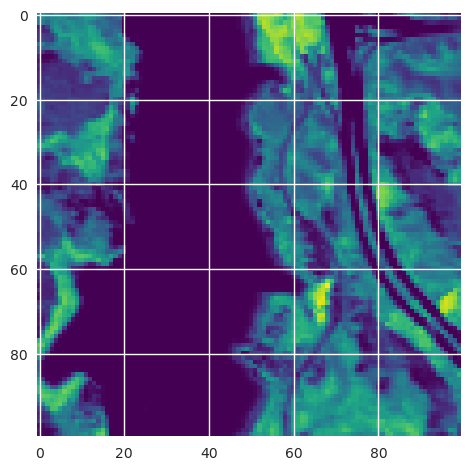

In [47]:
plt.imshow(A[0,2], cmap='viridis')
plt.show()